In [14]:
from ppget.source import ModelSource

start_date = "2007-07-01"
end_date = "2007-08-01"
feature = "Global_active_power"

source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: 10T, Name: Global_active_power, dtype: float64)

In [15]:
series = source.series()
series.head()

timestamp
2007-07-01 00:00:00    2.6812
2007-07-01 00:10:00    2.6502
2007-07-01 00:20:00    2.6266
2007-07-01 00:30:00    2.5242
2007-07-01 00:40:00    2.6000
Freq: 10T, Name: Global_active_power, dtype: float64

In [16]:
from ppget.datastructure import DatasetBuilder, TrainSplit

WINDOW = 48
MODEL_NAME = "model/cnn1D/"

builder = DatasetBuilder(series, data_split=TrainSplit(train=0.8, validation=0.1), window_size=WINDOW)

S = builder.build_splits()

S["training"]["X"].shape, S["training"]["y"].shape, S["validation"]["X"].shape, S["validation"]["y"].shape, S["test"]["X"].shape, S["test"]["y"].shape

((3532, 48, 1), (3532,), (441, 48, 1), (441,), (443, 48, 1), (443,))

In [17]:
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.losses import MeanSquaredError
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv1D, InputLayer, Flatten, Dense
from tensorflow.python.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(InputLayer((WINDOW, 1)))
model.add(Conv1D(64, kernel_size=2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
checkpoint = ModelCheckpoint(MODEL_NAME, save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 47, 64)            192       
_________________________________________________________________
flatten_2 (Flatten)          (None, 3008)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 24072     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 24,273
Trainable params: 24,273
Non-trainable params: 0
_________________________________________________________________


In [18]:
%%time
history = model.fit(S["training"]["X"], S["training"]["y"],
                    epochs=100,
                    validation_data=(S["validation"]["X"], S["validation"]["y"]),
                    verbose=2,
                    callbacks=[checkpoint])

Epoch 1/100
111/111 - 1s - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1286
INFO:tensorflow:Assets written to: cnn1D/assets
Epoch 2/100
111/111 - 0s - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
INFO:tensorflow:Assets written to: cnn1D/assets
Epoch 3/100
111/111 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
INFO:tensorflow:Assets written to: cnn1D/assets
Epoch 4/100
111/111 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
INFO:tensorflow:Assets written to: cnn1D/assets
Epoch 5/100
111/111 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018
INFO:tensorflow:Assets written to: cnn1D/assets
Epoch 6/100
111/111 - 0s - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0096 - val_root_m

In [19]:
from tensorflow.python.keras.models import load_model

model = load_model(MODEL_NAME)

predictions = model.predict(S["test"]["X"]).flatten()
len(predictions)

443

In [21]:
import pandas as pd

test_results = pd.DataFrame(data={"Predictions": builder.denormalise(predictions), "Ground Truth": builder.denormalise(S["test"]["y"])})
test_results

,Predictions,Ground Truth
0,1.049751,1.2148
1,1.132837,1.2666
2,1.125385,0.4182
3,0.317907,0.1020
4,0.127305,0.1808
...,...,...
438,0.459196,0.2134
439,0.264991,0.1364
440,0.307450,0.1986
441,0.230649,0.2518


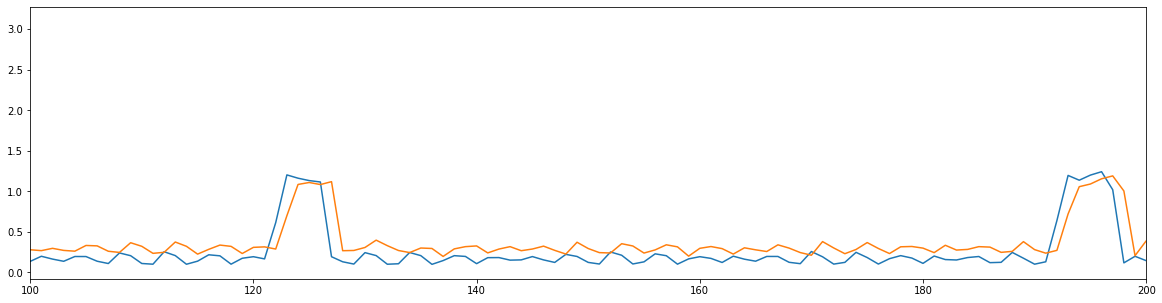

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mplt
mplt.rcParams["figure.figsize"] = (20,5)

# plt.xlim([100, 200])
plt.plot(test_results["Ground Truth"])
plt.plot(test_results["Predictions"])
plt.show()